## DATA IMPORT 

GOAL/ DATA EXPLANATION

Choose model and predict conversion rate + ideas to improve conversion

- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- **new_user** : whether the user created the account during this session or had already an account and simply came back to the site
- **source : marketing channel source**
 - Ads: came to the site by clicking on an advertisement
 - Seo: came to the site by clicking on search results
 - Direct: came to the site by directly typing the URL on the browser
- **total_pages_visited**: number of total pages visited during the session. This is a proxy for
time spent on site and engagement during the session.

converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions
/ total sessions.

In [59]:
#import des données
import pandas as pd
data=pd.read_csv("conversion_data.csv")
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [60]:
#verification des valeurs manquantes
data.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

## GRAPHS

In [61]:
#import libraries 
import seaborn as sns
import matplotlib.pyplot as plt

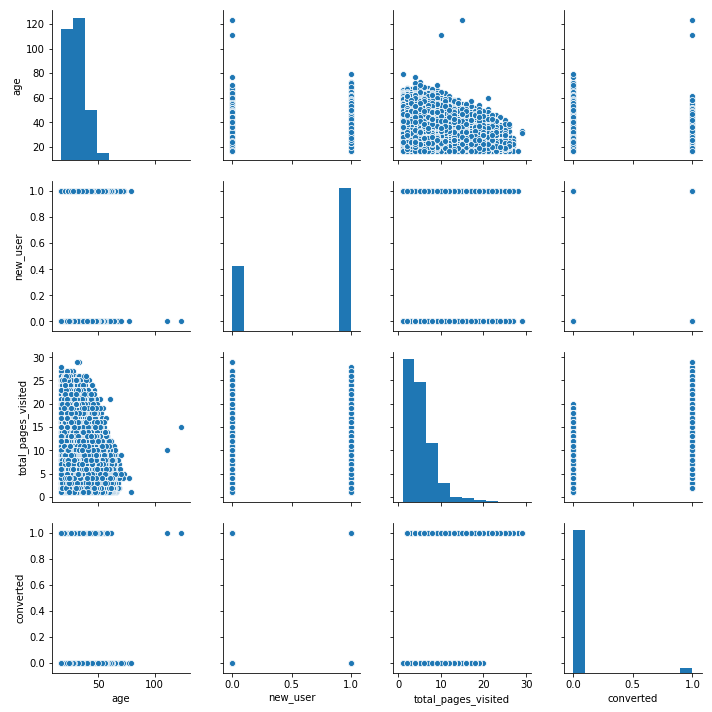

In [62]:
#overview du dataset
sns.pairplot(data)

In [63]:
data = data.query("age<100")


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


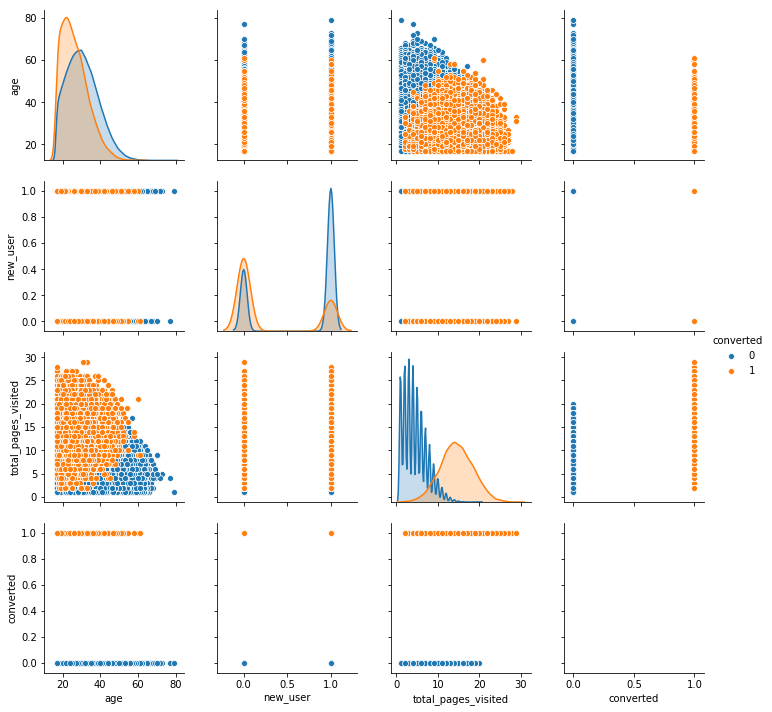

In [64]:
#overview du dataset en fonction de converted
sns.pairplot(data , hue="converted")

**We notice the difference in conversion rate between old users and new users**

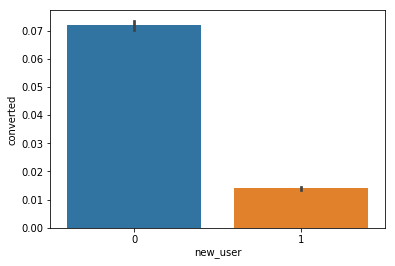

In [65]:
#detailed observation for new vs old users
sns.barplot(data=data,x="new_user",y="converted")

- Conversion probability for old user = 7% 
- Conversion probability for old user = 1%

**We therefore conclude that an old user has 7 more chances to convert than a new user**

Hypothesis: young people more susceptible to convert

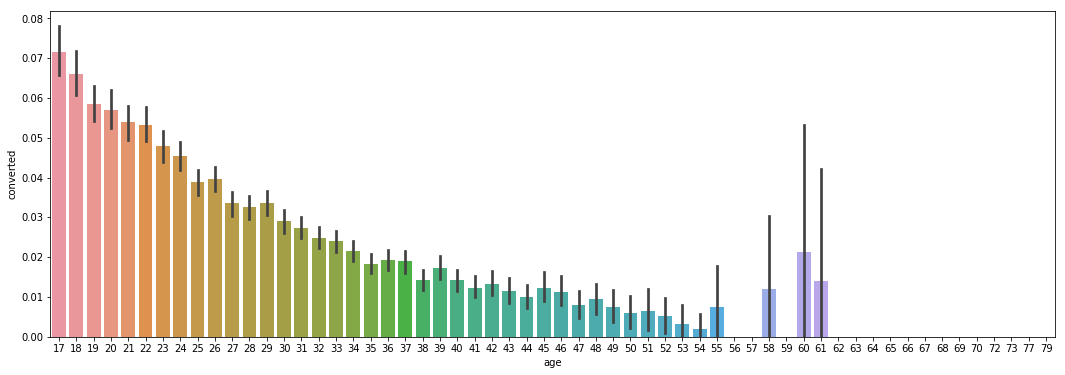

In [66]:
fig = plt.figure(figsize=(18, 6))
sns.barplot(data=data,y=data.converted ,x=data.age)

- the younger you are, the more likely you are to convert 
- Starting at 55, goes back up but given the confidence interval, we can't make any conclusions 

In [67]:
 #Modèle de Reglog avec toutes les colonnes

X=data.iloc[:,:-1]
y=data.iloc[:,-1]

import sklearn.model_selection as cv
Xtrain, Xtest, ytrain, ytest = cv.train_test_split(X, y, test_size = 0.3, random_state=0, stratify=y)

#Création des dummy variables
Xtrain=pd.get_dummies(Xtrain, drop_first=True)
Xtest=pd.get_dummies(Xtest, drop_first=True)

#Normalisation des données
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(Xtrain)
xtrain = sc.transform(Xtrain) # transformation des données train
xtest = sc.transform(Xtest) # transformation des données test


#Création modèles de Regression
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()
model_log = model_log.fit(xtrain, ytrain)

#Scores sur train et test: (calcul du R**2)
score_log = model_log.score(xtrain, ytrain), model_log.score(xtest, ytest)


print(model_log.coef_[0])
#print(score_log, model_log.coef_, Xtrain.columns)
#print(model_log.coef_)

df=pd.DataFrame({"features":Xtrain.columns,"coef":model_log.coef_[0]})
df


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[-0.60848952 -0.80121745  2.52041979  0.7319643   1.27493624  1.57056149
 -0.05467257  0.01129255]


,features,coef
0,age,-0.608490
1,new_user,-0.801217
2,total_pages_visited,2.520420
3,country_Germany,0.731964
4,country_UK,1.274936
5,country_US,1.570561
6,source_Direct,-0.054673
7,source_Seo,0.011293


- Coefficient analysis to understand most relevant features
- total_pages_visited stands out 
- English speaking also stand out
- Age: negative correlation (confirms earlier observation)

In [68]:
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=8).fit(Xtrain, ytrain)

df["score"]=X_new.scores_
df

,features,coef,score
0,age,-0.608490,3890.221587
1,new_user,-0.801217,1584.259081
2,total_pages_visited,2.520420,141904.046208
3,country_Germany,0.731964,246.806304
4,country_UK,1.274936,425.416740
5,country_US,1.570561,137.309461
6,source_Direct,-0.054673,34.170926
7,source_Seo,0.011293,5.140744


- confirms importance of variables (age,new_user,total_pages_visited)